# Agent-based model for News diffusion and misinformation

What I want to do is to create agents that share news, then from there find some interesting insights that could help fake news research

#### The first thing we need to do is to import news article and user classes

In [1]:
from classes import NewsArticle,User

1. Users attributes:  
  a. unique_id : a non-intelligent number given to the user  
  b. news_spread_chance : a percentage of the user spreading news (can be compared to confidence and censorship)   
  c. preference : the position the user feels about the current subject being discussed  
  d. type: the user could be a regular user or a news agency  
  e. articles : a list of articles shared by the user  
      
        
        
2. News articles attributes:  
  a. news_article_id : a non-intelligenct number given to the article  
  b. source_id : the id of the source  
  c. source_preference : the preference of the source  
  d. sentiment : a number from [1,5] or [-5,-1]  
  e. num_shares :  the number of people sharing the article  
  f. fake : 1 if the news is fake, otherwise real

#### Lets try to create a simple news article

In [2]:
x = NewsArticle(1,100,0.8,4,21,1)

In [3]:
x

News Article ID: 1
Source ID: 100
Source Preference: 0.8
Sentiment: 4
Number of shares: 21
Fake (True:1, False:0): 1

#### Now we need to try to create a few users

news_agencies_ratio is a network attribute to add that takes the amount of news agencies in the network  
number_of_users is a network attribute that creates a graph of a certain number of nodes equal to the number of users

In [177]:
from random import random, uniform, choice
from SimHelper import generate_weighted_percentage

users = []
news_agencies_ratio = 0.1
number_of_users = 100

for i in range(number_of_users):
    unique_id = i
    if random() < news_agencies_ratio:
        user_type = 'news_agency' 
    else:
        user_type = 'regular' 
        
    if user_type == 'news_agency':
        news_spread_chance = round(generate_weighted_percentage(0.8))
    else:
        news_spread_chance = round(random(),2)
    preference = round(uniform(-1,1),2)
    
    articles = []
    users.append(User(unique_id,news_spread_chance,preference,user_type,articles))

In [178]:
users[82]

User ID: 82
News Spread Chance: 0.73
Preference: 0.42
Type: regular

### Lets try to create a network of the users

In [179]:
import networkx as nx

In [180]:
G = nx.Graph()
G.add_nodes_from(users)

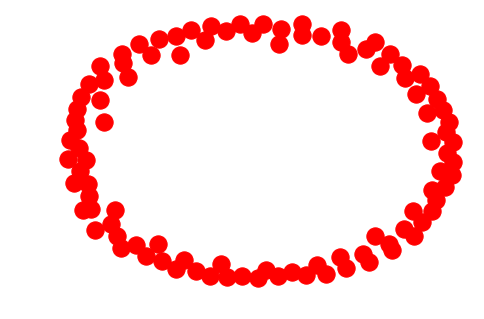

In [181]:
%matplotlib inline
nx.draw(G)

In [182]:
# G = nx.scale_free_graph(100)
# G = G.to_undirected()

In [183]:
color_map = []
for node in list(G.nodes()):
    if node.preference < -0.5:
        color_map.append('red')
    elif node.preference > 0.5:
        color_map.append('blue')
    else:
        color_map.append('grey')

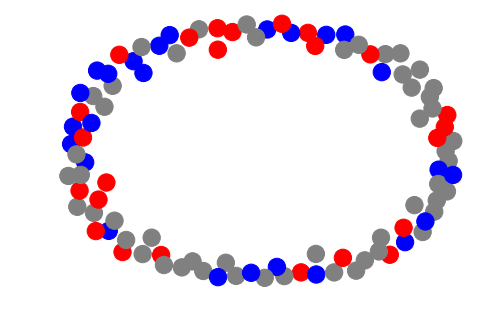

In [184]:
%matplotlib inline
nx.draw(G, node_color=color_map)

#### Add edges by Power law distribution

In [185]:
import numpy as np
import matplotlib.pyplot as plt

In [186]:
edge_list = []
for i in range(100):
    edge_list.append(int((np.random.pareto(a=10)+.1)*30))

In [187]:
edge_list

[3,
 4,
 4,
 3,
 7,
 8,
 11,
 3,
 7,
 3,
 4,
 3,
 5,
 5,
 5,
 6,
 3,
 4,
 4,
 4,
 3,
 8,
 3,
 3,
 3,
 4,
 4,
 6,
 3,
 9,
 3,
 4,
 10,
 4,
 8,
 5,
 3,
 8,
 6,
 4,
 6,
 4,
 8,
 4,
 4,
 5,
 3,
 3,
 7,
 4,
 4,
 6,
 5,
 3,
 3,
 16,
 4,
 4,
 6,
 4,
 9,
 5,
 5,
 4,
 7,
 5,
 3,
 8,
 6,
 5,
 6,
 7,
 3,
 3,
 26,
 9,
 3,
 5,
 4,
 3,
 7,
 3,
 3,
 5,
 4,
 23,
 3,
 3,
 5,
 5,
 5,
 9,
 11,
 5,
 3,
 7,
 3,
 8,
 6,
 7]

(array([50., 16.,  9.,  8.,  7.,  4.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 3.  ,  4.15,  5.3 ,  6.45,  7.6 ,  8.75,  9.9 , 11.05, 12.2 ,
        13.35, 14.5 , 15.65, 16.8 , 17.95, 19.1 , 20.25, 21.4 , 22.55,
        23.7 , 24.85, 26.  ]),
 <a list of 20 Patch objects>)

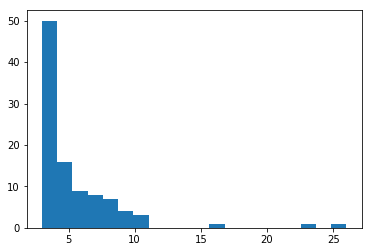

In [188]:
plt.hist(edge_list,bins=20)

In [189]:
from random import sample
for i in range(number_of_users):
    neighbors = sample(users,edge_list[i])
#     print(neighbors)
    for neighbor in neighbors:
      G.add_edge(users[i],neighbor)  

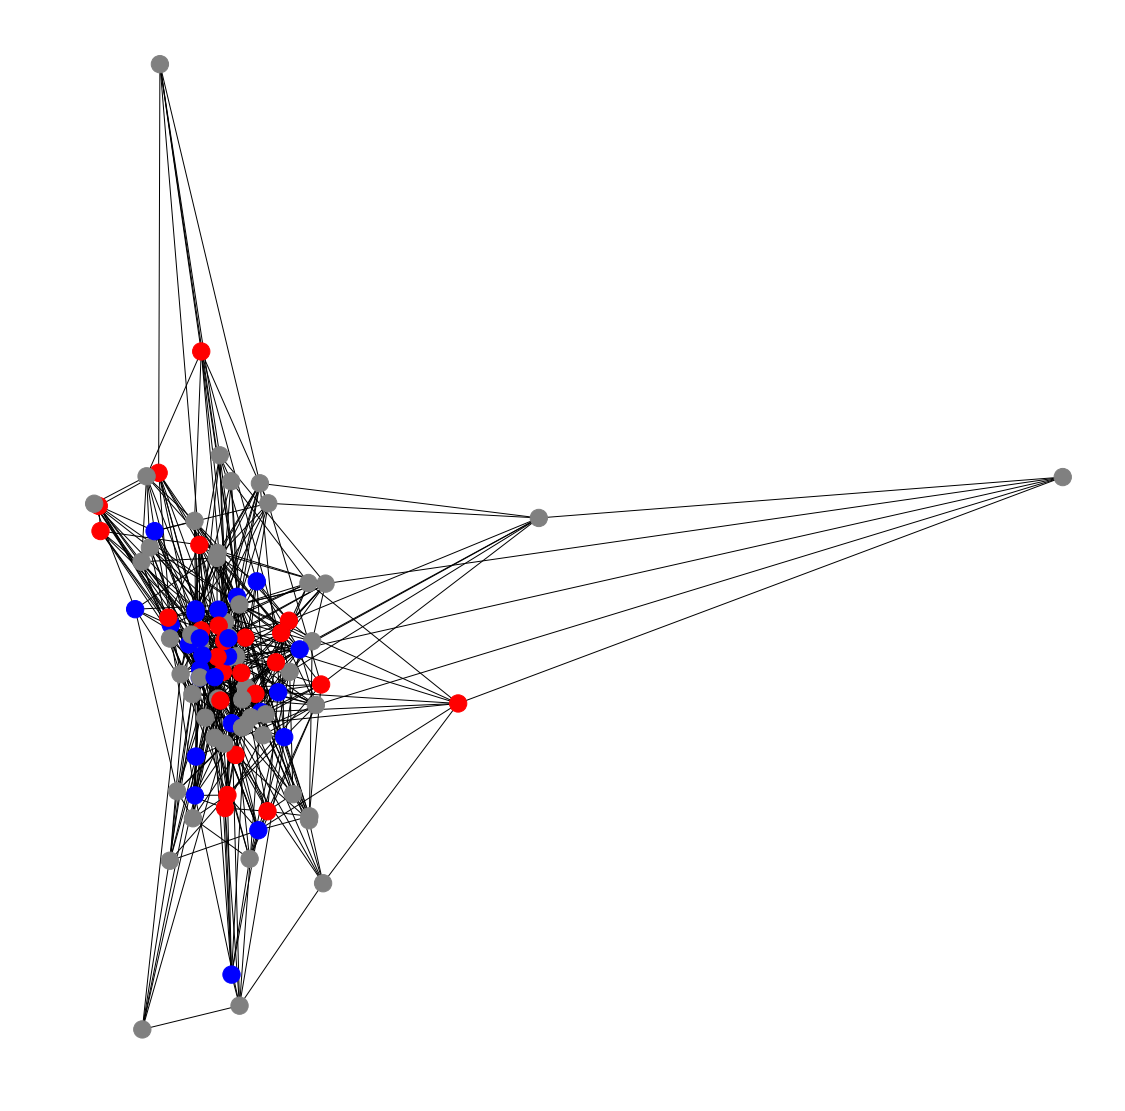

In [204]:
%matplotlib inline
# nx.draw_spectral(G, node_color=color_map)
pos = nx.spectral_layout(G)
plt.figure(1,figsize=(15,15))
nx.draw(G,pos, node_color=color_map)
plt.show()

In [197]:
import collections

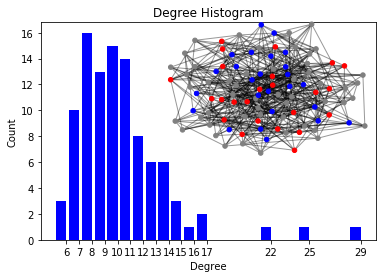

In [206]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=color_map)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

#### Lets spread some news and see how users change their preferences

For every time step t:  
- Make news events from the news agencies  
- Ask every agent to spread their articles across the network  
- Change the 'regular' user preference and compute overall network preference